## init

In [63]:
from pyfiles import (parametrics as par,
    complex as cplx,
    matrix as mat,
    vineyard as vin,
    input as inp,
    plot as ourplot,
    grid as grid,
    utils as utils,
    examples as ex
)
from pyfiles.examples import CameraOpt

# so we don't have to reboot kernel every time we modify classes.py
%load_ext autoreload
%autoreload 2

import numpy as np
from copy import deepcopy

from typing import *

import matplotlib.pyplot as plt
%matplotlib inline



def export_obj(ex: ex.Example, complex: cplx.complex, faces: List[np.ndarray]):
    out_name = ex.filename.replace('input', 'output')
    name = out_name.split('/')[-1]
    name = name.split('.')[0]
    filename = f'output/{name}-GB{ex.grid_buffer}-GS{ex.grid_size}-MA{ex.medial_axis}.obj'

    with open(filename, 'w') as f:
        vi = 1
        f.write(f'o {name}\n')
        for triangle in complex.trilist:
            a = triangle.coords[0]
            b = triangle.coords[1]
            c = triangle.coords[2]
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2}\n')
            vi += 3

        f.write(f'o {name}-MA{ex.medial_axis}\n')
        for [a, b, c, d] in faces:
            f.write(f'v {a[0]} {a[1]} {a[2]}\n')
            f.write(f'v {b[0]} {b[1]} {b[2]}\n')
            f.write(f'v {c[0]} {c[1]} {c[2]}\n')
            f.write(f'v {d[0]} {d[1]} {d[2]}\n')
            f.write(f'f {vi + 0} {vi + 1} {vi + 2} {vi + 3}\n')
            vi += 4


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


|======== Timed report ========
| bineyard.reduce sparse                         :       1.42ms  ( 1.424ms per; #1)
| vineyard.reduce_from_state ordering            :     314.57ms  ( 0.041ms per; #7644)
| vineyard.reduce_from_state transpositions_lean :      53.34ms  ( 0.007ms per; #7644)
| vineyard.reduce_from_state sparse matrix copies:    3141.57ms  ( 0.411ms per; #7644)
| low_inv                                        :      12.78ms  ( 0.006ms per; #2160)
| perform_one_swap case 1                        :      31.04ms  ( 0.014ms per; #2160)
| perform_one_swap                               :     121.95ms  ( 0.012ms per; #10371)
| perform_one_swap case 2                        :      15.56ms  ( 0.006ms per; #2476)
| perform_one_swap case 4                        :      14.57ms  ( 0.006ms per; #2453)
| perform_one_swap case 3                        :      37.54ms  ( 0.011ms per; #3282)
| vineyard.reduce_from_state sparse loop         :     182.58ms  ( 0.024ms per; #7644)
|============

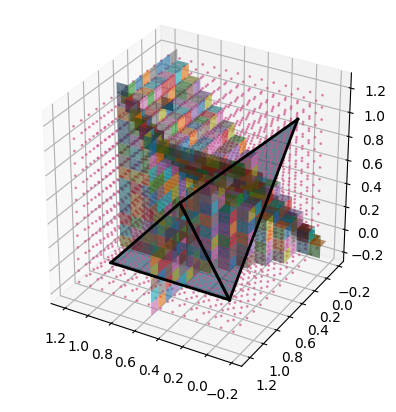

In [64]:
example = ex.hinge2

our_complex = inp.read_obj(example.filename)
gridd = grid.Grid3.from_complex(our_complex, example.grid_size, buffer=example.grid_buffer)

faces = []
class vineyard2(vin.vineyard):
  def on_faustian(self, s1: cplx.simplex, s2: cplx.simplex, a: np.ndarray, b: np.ndarray):
    super().on_faustian(s1, s2, a, b)
    if s1.dim() == 0:
      c1 = gridd.cell_of(a)
      c2 = gridd.cell_of(b)
      faces.append(gridd.dual_face(c1, c2))

v = vineyard2(our_complex)

def visit(new_cell: Tuple[int,int,int], old_cell: Tuple[int,int,int]):
  old_point = gridd.coordinate(old_cell)
  old_state = v.get_state_at_point(old_point)
  if old_state is None:
    (cx, cy, cz) = gridd.center_index()
    center_point = gridd.coordinate((cx, cy, cz))
    v.reduce(center_point)
  else:
    new_point = gridd.coordinate(new_cell)
    v.reduce_vine(old_state, new_point)

gridd.flood_fill_visit(gridd.center_index(), visit)
utils.Timed.report()

ourplot.plot_vineyard_results(our_complex, gridd, faces, CameraOpt(azim=120, elev=30))
export_obj(example, our_complex, faces)